# Load Dataset Pickle file

In [44]:
import pandas as pd

df = pd.read_pickle('./dataset/State_Hotel_reviews_v1_240415.01.pkl')

# Business/Solo Negative (1 or 2 顆星)

Location, Service, Sleep Quality, Cleanliness

In [8]:
version='240418.01'

In [9]:
#Location, Service, Sleep Quality, Cleanliness
travel_type = "Business/Solo"#"Friend/Couple", "Family", "Business/Solo"
df_business_neg = df[df['Travel Type Label'].str.contains(travel_type, na=False, regex=False)]
df_business_neg = df_business_neg [#df_business_neg ["Overall Rating"].isin([1, 2]) &
           #df_business_neg ["Value"].isin([1, 2]) &
           df_business_neg ["Location"].isin([1, 2]) &
           #df_business_neg ["Rooms"].isin([1, 2]) &
           df_business_neg ["Service"].isin([1, 2]) &
           df_business_neg ["Sleep Quality"].isin([1, 2]) &
           df_business_neg ["Cleanliness"].isin([1, 2])]

print(f'{travel_type} negative: {len(df_business_neg)}')

Business/Solo negative: 1993


In [10]:
df_sample = df_business_neg

In [11]:
#docs = df['text'].tolist()
docs = df_sample['token'].map(" ".join).tolist()
docs[:3]

['stay stay stayed 6 night hotel constant marijuana smell room swimming pool basically everywhere 3 time day minimum non smoking hotel easily see smoking weed balcony staff thing enforce rule got almost attacked homeless junky swimming pool penetrated hotel security anyone walk easily reach basically trying steal something people pool macbooks iphones chair everyone get pool quickly protect belonging afternoon yes yes happening 4 shore hotel nothing done result advise anyone stay hotel want feel like amsterdam weed coffee shop room pool people smoking marijuana 1st floor 1 meter child people swimming pool say stop throwing thing without hotel thing directly front desk go fairmont hotel sm really worthing star deal junky attacking marijuana smoker loud people yelling 8am pool neighbor listening music 1am staff thing make people stop really stay several hotel life never unpleasant unsafe experience 4 star hotel addition supposed offer champagne cup welcome ... still waiting',
 'scream ho

In [12]:
len(df_sample)

1993

In [34]:
%%time

import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"]="true"

from umap import UMAP
from hdbscan import HDBSCAN
#from cuml.cluster import HDBSCAN
#from cuml.manifold import UMAP
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer


seed = 42

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=10, #20,#15,
                  n_components=2,
                  min_dist=0.0,#0.05,
                  metric='cosine',
                  random_state=seed)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15,
                        metric='euclidean',
                        cluster_selection_method='eom',
                        prediction_data=True)

# Step 4 - Tokenize topics
#def tokenizer_split(text):
#    return text.split(',')

vectorizer_model = CountVectorizer(ngram_range=(2, 3), stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - (Optional) Fine-tune topic representations with
# a `bertopic.representation` model
representation_model = KeyBERTInspired(top_n_words=100)

# All steps together
topic_model = BERTopic(
    embedding_model=embedding_model,          # Step 1 - Extract embeddings
    umap_model=umap_model,                    # Step 2 - Reduce dimensionality
    hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
    vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
    ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
    representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic represenations
    top_n_words=100,
    #min_topic_size=100,
)

topics, probs = topic_model.fit_transform(docs)
#topic_model.fit_transform(docs)
#topic_model.reduce_topics(docs, nr_topics='auto') 

CPU times: user 22.9 s, sys: 2.02 s, total: 24.9 s
Wall time: 12.8 s


In [36]:
topic_model.save(f"./output/model_{travel_type.replace('/','-')}_pos_{version}")

2024-04-18 15:20:44,452 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [35]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,433,-1_hotel staff_hotel room_room service_hotel need,"[hotel staff, hotel room, room service, hotel ...",[trois estate disappointed disappointed ... wi...
1,0,1074,0_recommend hotel_hotel nice_good hotel_nice h...,"[recommend hotel, hotel nice, good hotel, nice...",[great place stay friendly staff efficient per...
2,1,171,1_room service_hotel room_checked hotel_room b...,"[room service, hotel room, checked hotel, room...",[please read stay let fill 5 week holiday clc ...
3,2,114,2_hotel room smelled_hotel clean_hotel filthy_...,"[hotel room smelled, hotel clean, hotel filthy...",[stay away whole hotel inside horrible propert...
4,3,92,3_amazing campground_good campground_campgroun...,"[amazing campground, good campground, campgrou...",[rv spot quick stay making way desert wanted c...
5,4,37,4_hotel nice_people loiterring hotel_accessibl...,"[hotel nice, people loiterring hotel, accessib...",[never returning terrible 2 night visit bowery...
6,5,35,5_hotel clean friendly_hotel clean_clean hotel...,"[hotel clean friendly, hotel clean, clean hote...",[hotel nice need good cleaning staff great jas...
7,6,19,6_roach room_roach hotel_room roach_roach bath...,"[roach room, roach hotel, room roach, roach ba...",[stay recommending family friend stay granddau...
8,7,18,7_hotel room_hotel able_quality hotel_hotel given,"[hotel room, hotel able, quality hotel, hotel ...",[high quality hotel walking distance state cap...


CPU times: user 3.47 s, sys: 99.9 ms, total: 3.57 s
Wall time: 540 ms


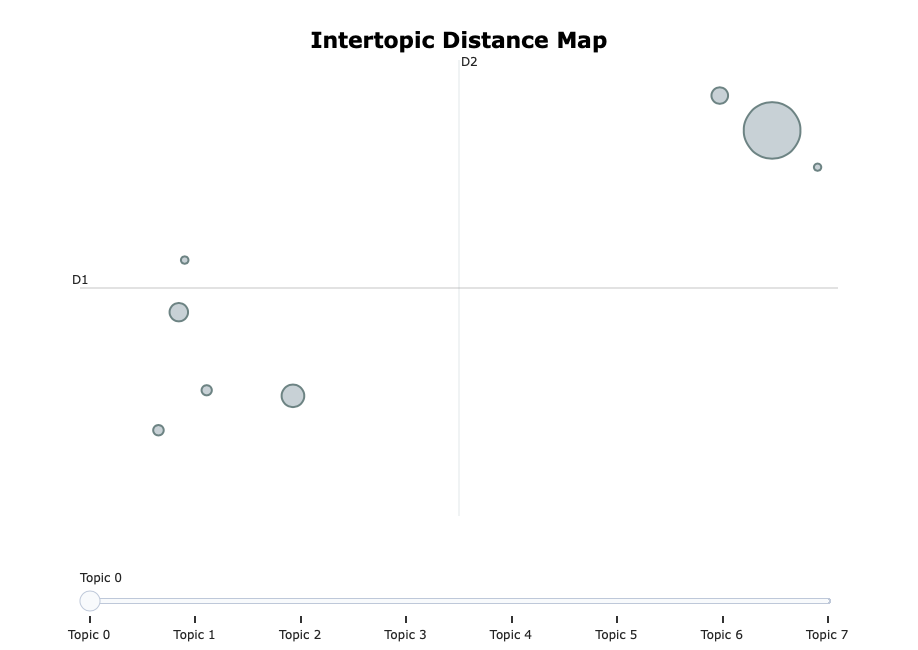

In [37]:
%%time

topic_model.visualize_topics()


CPU times: user 1min 1s, sys: 768 ms, total: 1min 2s
Wall time: 6.87 s


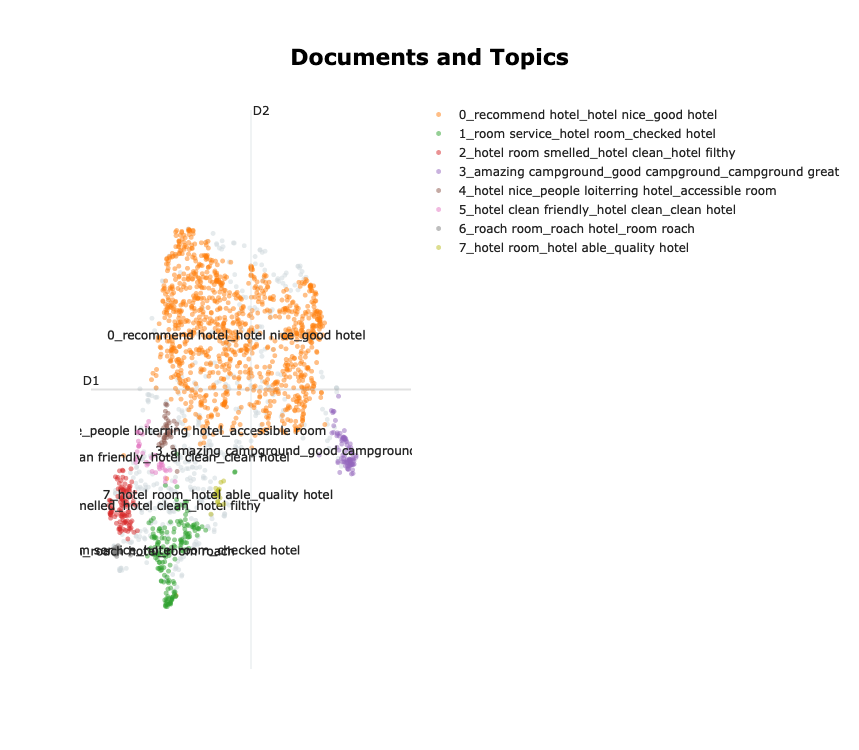

In [38]:
%%time

topic_model.visualize_documents(docs)


CPU times: user 54.2 ms, sys: 0 ns, total: 54.2 ms
Wall time: 53 ms


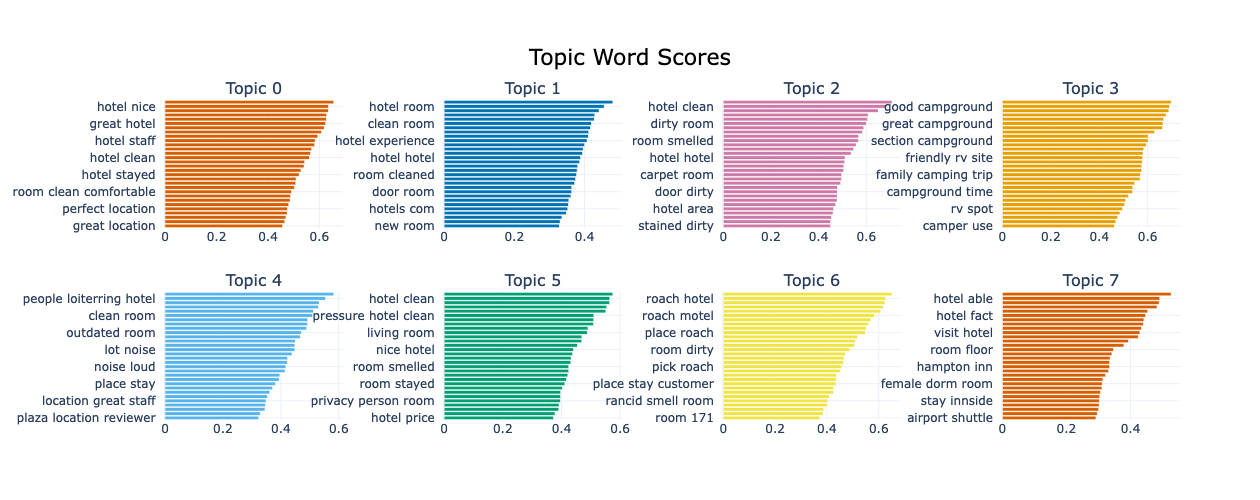

In [40]:
%%time

topic_model.visualize_barchart(topics=list(set(topics))[:8], n_words=30)


In [42]:
df_topickeywords = pd.DataFrame([topic_model.get_topic(i)
                                 for i in range(len(topic_model.topic_sizes_)-1)]).transpose()

df_topickeywords.to_pickle(f"./output/df_keywords_{travel_type.replace('/','-')}_pos_{version}.pkl")
df_topickeywords.to_csv(f"./output/keywords_{travel_type.replace('/','-')}_pos_{version}.csv",
                        encoding='utf-8', index=False)

df_topickeywords

,0,1,2,3,4,5,6,7
0,"(recommend hotel, 0.6556523)","(room service, 0.480865)","(hotel room smelled, 0.7082647)","(amazing campground, 0.69702446)","(hotel nice, 0.582731)","(hotel clean friendly, 0.57524574)","(roach room, 0.6510346)","(hotel room, 0.52685004)"
1,"(hotel nice, 0.63498497)","(hotel room, 0.45588002)","(hotel clean, 0.68401515)","(good campground, 0.68995225)","(people loiterring hotel, 0.55424136)","(hotel clean, 0.5647894)","(roach hotel, 0.6264634)","(hotel able, 0.49147695)"
2,"(good hotel, 0.63450223)","(checked hotel, 0.44144714)","(hotel filthy, 0.64994043)","(campground great, 0.68760306)","(accessible room, 0.5323131)","(clean hotel, 0.56374824)","(room roach, 0.6239784)","(quality hotel, 0.4892958)"
3,"(nice hotel, 0.62851465)","(room booked, 0.42921472)","(room dirty, 0.6080098)","(campground nice, 0.6761599)","(location room, 0.529628)","(room clean, 0.55416286)","(roach bathroom, 0.61775434)","(hotel given, 0.48267603)"
4,"(hotel great, 0.6265243)","(worst hotel experience, 0.42768875)","(room cleaned, 0.60586333)","(campground love, 0.66651595)","(room noisy, 0.5126149)","(room cleaned, 0.55119926)","(hotel roach, 0.6075733)","(hotel lobby, 0.4540972)"
...,...,...,...,...,...,...,...,...
95,"(walking distance, 0.12001024)","(ant infestation, 0.048843235)","(vista suite, 0.10843023)","(cell reception, 0.094879754)","(pay extra money, 0.071855485)","(paint red, 0.09022652)","(la quinta, 0.077026516)","(felt good, 0.02937842)"
96,"(felt like, 0.110098556)","(mr cicatello, 0.041106045)","(paint peeling, 0.076928884)","(electrical box, 0.088374354)","(plug left, 0.07038206)","(charge price, 0.063938074)","(property worth, 0.07656378)","(10 minute, 0.025166094)"
97,"(feel like, 0.07992029)","(gm pamela, 0.025970928)","(know star, 0.059204675)","(red ant, 0.08552791)","(pleased double, 0.06386879)","(paint red paint, 0.060755905)","(big fat, 0.072375305)","(october 2020, -0.009011827)"
98,"(time square, 0.077720016)","(year old, 0.0043073744)","(building sway, 0.04707376)","(office staff, 0.08132182)","(30 pm, 0.0559333)","(old run, 0.045156654)","(quinta like second, 0.067199335)","(november 2020, -0.0103762625)"


In [43]:
for i in range(len(topic_model.topic_sizes_)-1):
    print(f'### Topic {i}:')
    print(f'```python!')
    print(f'{[item[0] for item in topic_model.get_topic(i)[:30]]}')
    print(f'```')

### Topic 0:
```python!
['recommend hotel', 'hotel nice', 'good hotel', 'nice hotel', 'hotel great', 'great hotel', 'great place stay', 'hotel room', 'room hotel', 'hotel staff', 'clean hotel', 'great restaurant', 'hotel stay', 'hotel clean', 'stay hotel', 'stayed hotel', 'room service', 'hotel stayed', 'friendly room', 'place stay', 'great place', 'room clean comfortable', 'comfortable room', 'room spacious', 'helpful room', 'perfect location', 'location perfect', 'clean room', 'location great', 'great location']
```
### Topic 1:
```python!
['room service', 'hotel room', 'checked hotel', 'room booked', 'worst hotel experience', 'clean room', 'hotel stay', 'booked room', 'hotel management', 'hotel experience', 'staying hotel', 'stay hotel', 'hotel time', 'hotel hotel', 'hotel stayed', 'stayed hotel', 'room available', 'room cleaned', 'hilton hotel', 'hotel night', 'booked hotel', 'door room', 'room day', 'worst hotel', 'given room', 'hotels com', 'room door', 'told room', 'house keepin